In [1]:
# %matplotlib inline
from io import StringIO
import zipfile

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn import (dummy, ensemble, linear_model, metrics,
                     model_selection, neighbors, neural_network, 
                     preprocessing, svm, tree)
from yellowbrick import features, regressor
from yellowbrick import model_selection as ms_yb
import xgbfir
import xgboost as xgb

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.


## Data

In [2]:
# https://archive.ics.uci.edu/ml/datasets/Automobile
auto_cols = '''symboling
normalized-losses
make
fuel-type
aspiration
num-of-doors
body-style
drive-wheels
engine-location
wheel-base
length
width
height
curb-weight
engine-type
num-of-cylinders
engine-size
fuel-system
bore
stroke
compression-ratio
horsepower
peak-rpm
city-mpg
highway-mpg
price'''.split('\n')
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data'
auto = pd.read_csv('../data/imports-85.data', names=auto_cols)

In [9]:
auto.T

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
symboling,3,3,1,2,2,2,1,1,1,0,...,-1,-2,-1,-2,-1,-1,-1,-1,-1,-1
normalized-losses,?,?,?,164,164,?,158,?,158,?,...,74,103,74,103,74,95,95,95,95,95
make,alfa-romero,alfa-romero,alfa-romero,audi,audi,audi,audi,audi,audi,audi,...,volvo,volvo,volvo,volvo,volvo,volvo,volvo,volvo,volvo,volvo
fuel-type,gas,gas,gas,gas,gas,gas,gas,gas,gas,gas,...,gas,gas,gas,gas,gas,gas,gas,gas,diesel,gas
aspiration,std,std,std,std,std,std,std,std,turbo,turbo,...,std,std,std,turbo,turbo,std,turbo,std,turbo,turbo
num-of-doors,two,two,two,four,four,two,four,four,four,two,...,four,four,four,four,four,four,four,four,four,four
body-style,convertible,convertible,hatchback,sedan,sedan,sedan,sedan,wagon,sedan,hatchback,...,wagon,sedan,wagon,sedan,wagon,sedan,sedan,sedan,sedan,sedan
drive-wheels,rwd,rwd,rwd,fwd,4wd,fwd,fwd,fwd,fwd,4wd,...,rwd,rwd,rwd,rwd,rwd,rwd,rwd,rwd,rwd,rwd
engine-location,front,front,front,front,front,front,front,front,front,front,...,front,front,front,front,front,front,front,front,front,front
wheel-base,88.6,88.6,94.5,99.8,99.4,99.8,105.8,105.8,105.8,99.5,...,104.3,104.3,104.3,104.3,104.3,109.1,109.1,109.1,109.1,109.1


In [10]:
auto.dtypes

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-ratio    float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object

In [11]:
auto['num-of-doors']

0       two
1       two
2       two
3      four
4      four
       ... 
200    four
201    four
202    four
203    four
204    four
Name: num-of-doors, Length: 205, dtype: object

## Linear Regression

In [3]:
def tweak_cars(auto):
    return (auto
            .query('horsepower != "?" and price != "?"'
                  ' and bore != "?" and stroke != "?"')
            .rename({c:c.replace('-', '_') for c in auto.columns}, axis=1)
            .replace({'num_of_doors': {'?': 4, 'four': 4, 'two': 2}})
            .replace({'num_of_cylinders': {'two': 2, 'three': 3,'four': 4, 'five': 5,
                                           'six': 6, 'eight':8, 'twelve':12}})
            .assign(horsepower=lambda df: pd.to_numeric(df.horsepower),
                    peak_rpm=lambda df: pd.to_numeric(df.peak_rpm),
                    price=lambda df: pd.to_numeric(df.price),
                    bore=lambda df: pd.to_numeric(df.bore),
                    stroke=lambda df: pd.to_numeric(df.stroke))
            .drop(columns=['normalized_losses', 'highway_mpg'])
            .pipe(lambda df: pd.get_dummies(df, drop_first=True))
           )

def getX_y(df, y_col):
    return df.drop(columns=[y_col]), df[y_col]

auto2 = tweak_cars(auto)
auto_X, auto_y = getX_y(auto2, 'city_mpg')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


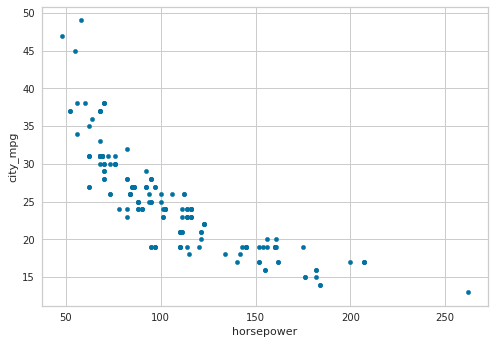

In [23]:
auto2.plot.scatter(x='horsepower', y='city_mpg')

In [21]:
# very simple
lr = linear_model.LinearRegression()
lr.fit(auto2[['horsepower']], auto2.city_mpg)
lr.score(auto2[['horsepower']], auto2.city_mpg)


0.695750394577362

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[<matplotlib.lines.Line2D at 0x7fd4e0cae160>]

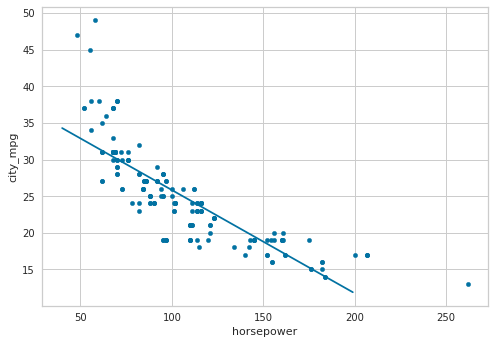

In [24]:
ax = auto2.plot.scatter(x='horsepower', y='city_mpg')
xs = np.arange(40, 200)
ax.plot(xs, xs*lr.coef_ + lr.intercept_)

In [25]:
# Let's use all of the columns
# Baseline model - default strategy is to always predict mean
dm = dummy.DummyRegressor()
dm.fit(auto_X, auto_y)
dm.score(auto_X, auto_y)

0.0

In [16]:
# Score is R2 score - coefficient of determintation
# Usually between 0-1 - .92 amount that answer is explained by features
# 1 - 100% of answer is explained by features
lr = linear_model.LinearRegression()
lr.fit(auto_X, auto_y)
lr.score(auto_X, auto_y)

0.9241524729272544

In [19]:
pd.Series(lr.coef_, auto_X.columns)

symboling                0.074225
num_of_doors            -0.167504
wheel_base              -0.291534
length                  -0.001245
width                    0.428865
height                   0.112654
curb_weight             -0.008915
num_of_cylinders        -1.491269
engine_size              0.023424
bore                    -2.716079
stroke                   0.551561
compression_ratio        1.625628
horsepower              -0.035480
peak_rpm                -0.002356
price                    0.000217
make_audi                2.354966
make_bmw                 4.990124
make_chevrolet          12.204181
make_dodge               6.247978
make_honda               3.504309
make_isuzu               4.379448
make_jaguar              8.648577
make_mazda               4.454062
make_mercedes-benz       6.489064
make_mercury             7.993692
make_mitsubishi          6.225264
make_nissan              5.712407
make_peugot              6.181748
make_plymouth            7.031110
make_porsche  

In [20]:
lr.intercept_

40.70273477102066

## Lab Data
Ames Housing Dataset
http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls

In [4]:
# Ames Housing Dataset
ames_url = '../data/AmesHousing.xls'
ames_df = pd.read_excel(ames_url)


In [30]:
ames_df

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


In [5]:
ames_df2 = (ames_df
           .select_dtypes('number')
           .dropna()
           )
ames_X, ames_y = getX_y(ames_df2, 'SalePrice')                           

## Regression Exercise
* Create a regression model for the Ames dataset
* What is the "score" of your model?


In [40]:
# Let's use all of the columns
# Baseline model - default strategy is to always predict mean
dm = dummy.DummyRegressor()
dm.fit(ames_X, ames_y)
dm.score(ames_X, ames_y)


0.0

In [41]:
# Score is R2 score - coefficient of determintation
# Usually between 0-1 - .92 amount that answer is explained by features
# 1 - 100% of answer is explained by features
lr = linear_model.LinearRegression()
lr.fit(ames_X, ames_y)
lr.score(ames_X, ames_y)

0.8410926779353429

## Splitting Data


In [6]:
def get_train_test_X_y(auto, y_col, size=.3, standardize=True):
    """We don't want to impute or standardize on the whole dataset
    else we are 'leaking' data"""
    y = auto[y_col]
    X = auto.drop(columns=y_col)
    X_train, X_test, y_train, y_test = \
       model_selection.train_test_split(
       X, y, test_size=size, random_state=42)
    cols = X.columns
    X_train = pd.DataFrame(X_train, columns=cols)
    X_test = pd.DataFrame(X_test, columns=cols)
    if standardize:
        std = preprocessing.StandardScaler()
        X_train = pd.DataFrame(std.fit_transform(X_train), columns=cols,
                              index=y_train.index)
        X_test = pd.DataFrame(std.transform(X_test), columns=cols,
                             index=y_test.index)

    return X_train, X_test, y_train, y_test

auto_X_train, auto_X_test, auto_y_train, auto_y_test = \
    get_train_test_X_y(auto2, 'city_mpg') 

In [43]:
# Baseline model - default strategy is to always predict mean
dm = dummy.DummyRegressor()
dm.fit(auto_X_train, auto_y_train)
dm.score(auto_X_test, auto_y_test)

-0.008375301333473306

In [44]:
# Score is R2 score - coefficient of determintation
# Usually between 0-1 - .76 amount that answer is explained by features
# 1 - 100% of answer is explained by features
lr = linear_model.LinearRegression()
lr.fit(auto_X_train, auto_y_train)
lr.score(auto_X_test, auto_y_test)

0.8491695166820306

In [45]:
lr.score(auto_X_train, auto_y_train)

0.9361167183390618

## Splitting Exercise
* Split the Ames data into a training and testing set
* Run a regression model against the new data, what is the score?

In [7]:
ames_X_train, ames_X_test, ames_y_train, ames_y_test = \
    get_train_test_X_y(ames_df2, 'SalePrice') 

In [48]:
lr = linear_model.LinearRegression()
lr.fit(ames_X_train, ames_y_train)
lr.score(ames_X_test, ames_y_test)

0.8080864059933974

## Model Evaluation

In [49]:
lr = linear_model.LinearRegression()
lr.fit(auto_X_train, auto_y_train)
lr.score(auto_X_test, auto_y_test)

0.8491695166820306

In [51]:
metrics.r2_score(auto_y_test, lr.predict(auto_X_test))

0.8491695166820306

In [53]:
# average error (but can't indicate direction of error)
metrics.mean_squared_error(auto_y_test, lr.predict(auto_X_test))

7.803755158440944

In [52]:
# penalizes large errors
metrics.mean_absolute_error(auto_y_test, lr.predict(auto_X_test))

1.7548188413146677

In [54]:
dt = tree.DecisionTreeRegressor(max_depth=4)
dt.fit(auto_X_train, auto_y_train)
dt.score(auto_X_test, auto_y_test)

0.8972713747824278

In [55]:
metrics.mean_absolute_error(auto_y_test, dt.predict(auto_X_test))

1.4967162614719938

In [56]:
metrics.mean_squared_error(auto_y_test, dt.predict(auto_X_test))

5.315033283233317

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


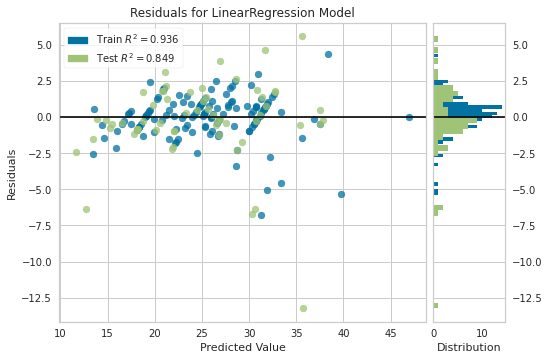

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd51a80c6a0>,
              hist=True, is_fitted='auto', line_color=None, model=None,
              test_alpha=None, test_color=None, train_alpha=None,
              train_color=None)

In [57]:
# Residuals plot 
# Good for looking at homoskedasticity - variance of errors
regressor.residuals_plot(lr, auto_X_train, auto_y_train, auto_X_test, auto_y_test)

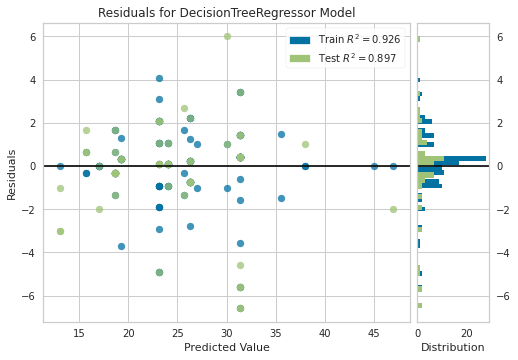

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4e1039a90>,
              hist=True, is_fitted='auto', line_color=None, model=None,
              test_alpha=None, test_color=None, train_alpha=None,
              train_color=None)

In [58]:
# Residuals plot 
# Good for looking at homoskedasticity - variance of errors
regressor.residuals_plot(dt, auto_X_train, auto_y_train, auto_X_test, auto_y_test)

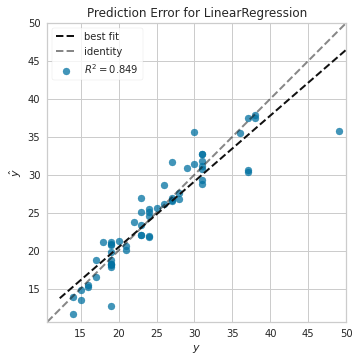

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


PredictionError(alpha=0.75,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd51d1cc048>,
                bestfit=True, identity=True, is_fitted='auto', model=None,
                shared_limits=True)

In [59]:
# Prediction Error 
# Good for looking at variance and performance at different ends
regressor.prediction_error(lr, auto_X_train, auto_y_train, auto_X_test, auto_y_test)

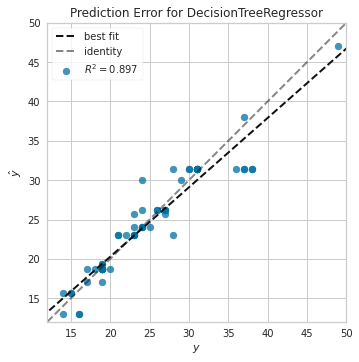

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


PredictionError(alpha=0.75,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd51d1bdef0>,
                bestfit=True, identity=True, is_fitted='auto', model=None,
                shared_limits=True)

In [61]:
# Prediction Error 
# Good for looking at variance and performance at different ends
regressor.prediction_error(dt, auto_X_train, auto_y_train, auto_X_test, auto_y_test)

## Evaluation Exercise
* Create a decision tree model for the housing data
* Compare the r2 and MSE for the decision tree and linear regression models.
* Plot a residuals plot for both models.

In [65]:
lr = linear_model.LinearRegression()
lr.fit(ames_X_train, ames_y_train)
lr.score(ames_X_test, ames_y_test)

0.8080864059933974

In [66]:
metrics.mean_squared_error(ames_y_test, lr.predict(ames_X_test))

1388713297.4731386

In [82]:
f'{metrics.mean_squared_error(ames_y_test, lr.predict(ames_X_test)):,.2f}'

'1,388,713,297.47'

In [69]:
dt = tree.DecisionTreeRegressor()
dt.fit(ames_X_train, ames_y_train)
dt.score(ames_X_test, ames_y_test)

0.8042573710881568

In [70]:
metrics.mean_squared_error(ames_y_test, dt.predict(ames_X_test))

1416420723.3953147

In [81]:
f'{metrics.mean_squared_error(ames_y_test, dt.predict(ames_X_test)):,.2f}'

'1,416,420,723.40'

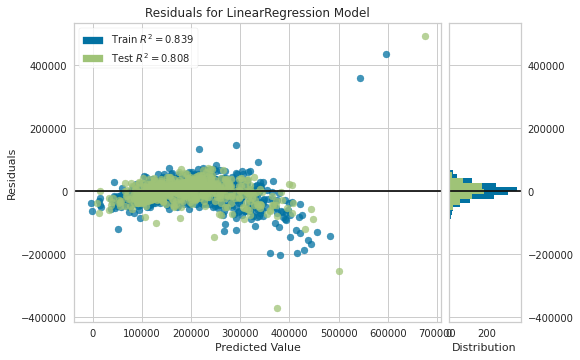

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd51ced7668>,
              hist=True, is_fitted='auto', line_color=None, model=None,
              test_alpha=None, test_color=None, train_alpha=None,
              train_color=None)

In [71]:
regressor.residuals_plot(lr, ames_X_train, ames_y_train, ames_X_test, ames_y_test)

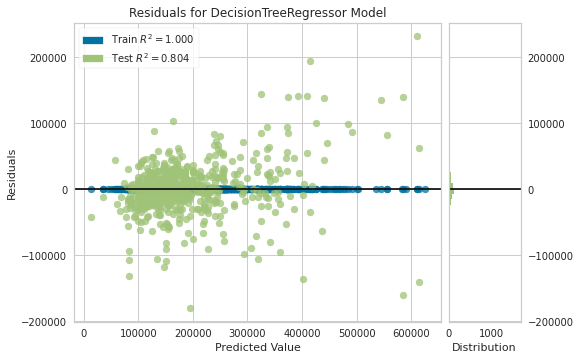

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd51cefdc88>,
              hist=True, is_fitted='auto', line_color=None, model=None,
              test_alpha=None, test_color=None, train_alpha=None,
              train_color=None)

In [72]:
regressor.residuals_plot(dt, ames_X_train, ames_y_train, ames_X_test, ames_y_test)

## Tuning the Model

In [83]:
dt = tree.DecisionTreeRegressor(max_depth=None)
dt.fit(auto_X_train, auto_y_train)
dt.score(auto_X_test, auto_y_test)

0.9269469522825954

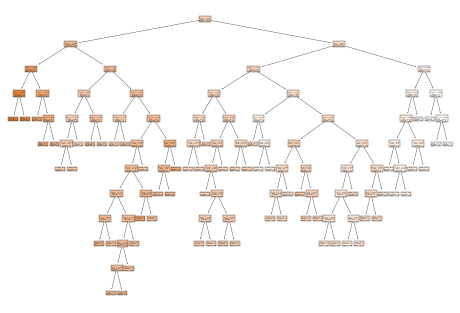

In [86]:
_=tree.plot_tree(dt, filled=True)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


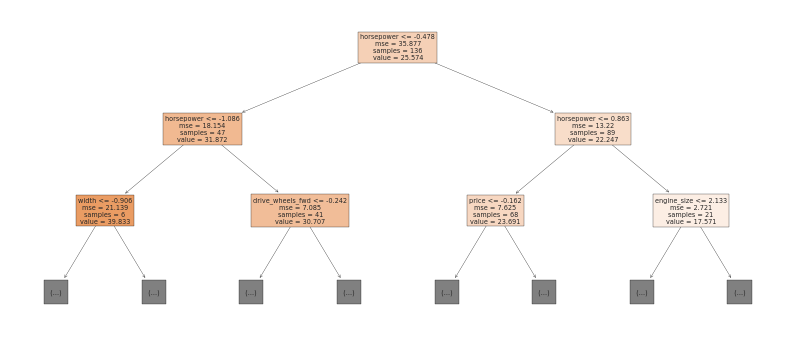

In [92]:
fig, ax = plt.subplots(figsize=(14,6))
_=tree.plot_tree(dt, max_depth=2, filled=True, feature_names=auto_X.columns, ax=ax)

In [101]:
print(tree.export_text(dt, feature_names=list(auto_X.columns)))

|--- horsepower <= -0.48
|   |--- horsepower <= -1.09
|   |   |--- width <= -0.91
|   |   |   |--- width <= -1.80
|   |   |   |   |--- value: [47.00]
|   |   |   |--- width >  -1.80
|   |   |   |   |--- value: [45.00]
|   |   |--- width >  -0.91
|   |   |   |--- price <= -0.70
|   |   |   |   |--- value: [38.00]
|   |   |   |--- price >  -0.70
|   |   |   |   |--- curb_weight <= -0.53
|   |   |   |   |   |--- value: [37.00]
|   |   |   |   |--- curb_weight >  -0.53
|   |   |   |   |   |--- value: [34.00]
|   |--- horsepower >  -1.09
|   |   |--- drive_wheels_fwd <= -0.24
|   |   |   |--- drive_wheels_rwd <= 0.32
|   |   |   |   |--- price <= -0.54
|   |   |   |   |   |--- price <= -0.65
|   |   |   |   |   |   |--- value: [26.00]
|   |   |   |   |   |--- price >  -0.65
|   |   |   |   |   |   |--- value: [27.00]
|   |   |   |   |--- price >  -0.54
|   |   |   |   |   |--- value: [24.00]
|   |   |   |--- drive_wheels_rwd >  0.32
|   |   |   |   |--- fuel_type_gas <= -1.24
|   |   |   | 

In [105]:
# This model is overfitting
# (hint: performs well on training data, but worse on testing)
dt.score(auto_X_train, auto_y_train)

1.0

In [104]:
dt.score(auto_X_test, auto_y_test)

0.9269469522825954

In [15]:
stump = tree.DecisionTreeRegressor(max_depth=1)
stump.fit(auto_X_train, auto_y_train)
stump.score(auto_X_test, auto_y_test)

0.567103923314265

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


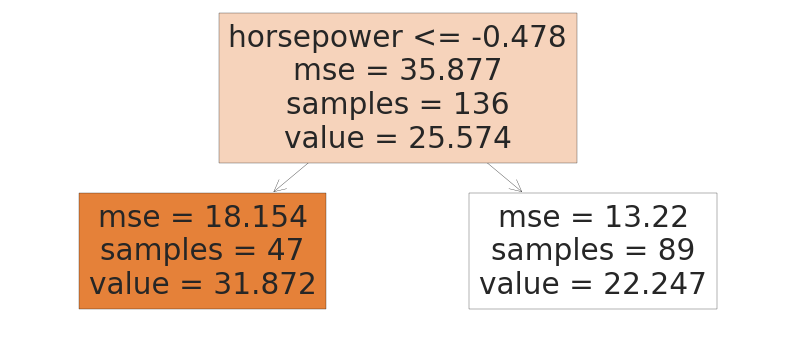

In [108]:
fig, ax = plt.subplots(figsize=(14,6))
_=tree.plot_tree(stump, max_depth=2, filled=True, feature_names=auto_X.columns, ax=ax)

In [11]:
for i in range(1, 10):
    model = tree.DecisionTreeRegressor(max_depth=i)
    model.fit(auto_X_train, auto_y_train)
    print(i, model.score(auto_X_test, auto_y_test) )

1 0.567103923314265
2 0.7936885186212939
3 0.888650385168128
4 0.9028404412003466
5 0.9301384830307199
6 0.9269677524327099
7 0.9348393897617456
8 0.9416580795419982
9 0.9211696828587257


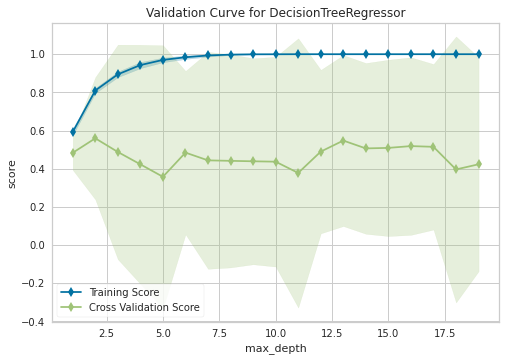

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f20c1f02d30>,
                cv=None, groups=None, logx=False, model=None, n_jobs=1,
                param_name='max_depth',
                param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                pre_dispatch='all', scoring=None)

In [13]:
ms_yb.validation_curve(tree.DecisionTreeRegressor(),  
    auto_X, auto_y, param_name='max_depth', param_range=range(1, 20))

In [18]:
# many "hyperparameters"
stump

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [20]:
param_grid = {'random_state': [42],
             'max_depth': [1,2,5,10,20],
             'min_impurity_decrease': [0, .1, .2, .5]}
grid = model_selection.GridSearchCV(tree.DecisionTreeRegressor(), param_grid=param_grid)
grid.fit(auto_X, auto_y)



GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 5, 10, 20],
                         'min_impurity_decrease': [0, 0.1, 0.2, 0.5],
                         

In [22]:
grid.best_params_

{'max_depth': 2, 'min_impurity_decrease': 0, 'random_state': 42}

In [23]:
tuned_dt = tree.DecisionTreeRegressor(**grid.best_params_)

## Tuning Exercise
* Tune a decision tree for the Ames data
* What is the score?

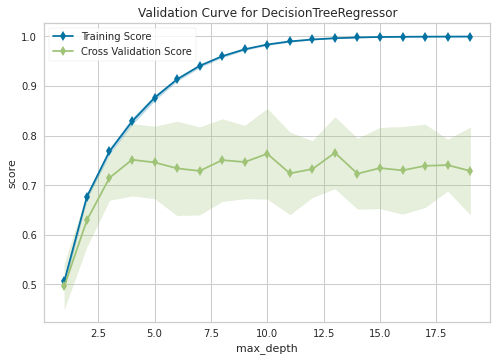

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f20c0abdeb8>,
                cv=None, groups=None, logx=False, model=None, n_jobs=1,
                param_name='max_depth',
                param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                pre_dispatch='all', scoring=None)

In [58]:
ms_yb.validation_curve(tree.DecisionTreeRegressor(random_state=42),  
    ames_X, ames_y, param_name='max_depth', param_range=range(1, 20))

In [28]:
# different from above? - This uses 5-fold validation above is 3
param_grid = {'random_state': [42],
             'max_depth': [1,2,5,8,10,20],
             'min_impurity_decrease': [0, .1, .2, .5]}
grid = model_selection.GridSearchCV(tree.DecisionTreeRegressor(), param_grid=param_grid)
grid.fit(ames_X, ames_y)



GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 5, 8, 10, 20],
                         'min_impurity_decrease': [0, 0.1, 0.2, 0.5],
                      

In [29]:
grid.best_params_

{'max_depth': 10, 'min_impurity_decrease': 0, 'random_state': 42}

In [46]:
tuned_ames = tree.DecisionTreeRegressor(**grid.best_params_)
tuned_ames.fit(ames_X_train, ames_y_train)
tuned_ames.score(ames_X_test, ames_y_test)

0.8157095876969717

In [45]:
dt_ames = tree.DecisionTreeRegressor()  # value will change w/o random state
dt_ames.fit(ames_X_train, ames_y_train)
dt_ames.score(ames_X_test, ames_y_test)

0.8036755074837455

## Explaining the Model

In [59]:
dt = tree.DecisionTreeRegressor(max_depth=10)
dt.fit(auto_X_train, auto_y_train)
dt.score(auto_X_test, auto_y_test)

0.9383307792251058

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


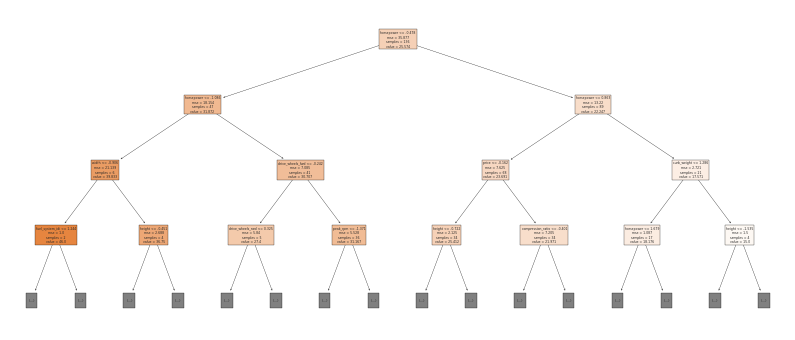

In [60]:
fig, ax = plt.subplots(figsize=(14,6))
_=tree.plot_tree(dt, max_depth=3, filled=True, feature_names=auto_X.columns, ax=ax)

In [62]:
dt.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 2.16315727e-03, 6.42856282e-03,
       2.35202981e-02, 1.34906635e-02, 1.23946706e-02, 0.00000000e+00,
       0.00000000e+00, 7.87426100e-03, 9.47026785e-04, 3.13923486e-02,
       8.16315684e-01, 1.01592737e-02, 5.18375620e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.36646612e-04,
       2.83769464e-03, 0.00000000e+00, 0.00000000e+00, 1.75688501e-04,
       6.83233059e-04, 0.00000000e+00, 0.00000000e+00, 1.02972982e-03,
       0.00000000e+00, 1.27671262e-02, 4.75530209e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.81130803e-04, 4.09939835e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [66]:
pd.Series(dt.feature_importances_, auto_X.columns).sort_values().tail(10)

length               0.006429
bore                 0.007874
peak_rpm             0.010159
curb_weight          0.012395
drive_wheels_fwd     0.012767
height               0.013491
width                0.023520
compression_ratio    0.031392
price                0.051838
horsepower           0.816316
dtype: float64

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


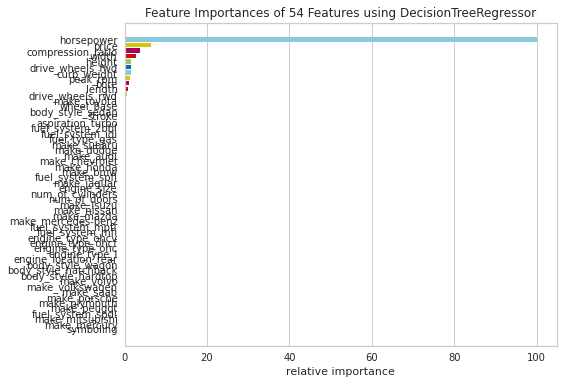

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


FeatureImportances(absolute=False,
                   ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f20c095b4a8>,
                   colormap=None, colors=None, is_fitted='auto', labels=None,
                   model=None, relative=True, stack=False, xlabel=None)

In [61]:
ms_yb.feature_importances(dt, auto_X, auto_y)

In [67]:
# Shap - Interpret black box models
shap_ex = shap.TreeExplainer(dt)
vals = shap_ex.shap_values(auto_X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [69]:
dt.predict(auto_X_test.iloc[[0]])  # prediction

array([26.])

In [71]:
auto_y_test.iloc[0]  # actual

23

In [74]:
auto_X_test.iloc[[0]].T

,148
symboling,-0.614362
num_of_doors,0.811503
wheel_base,-0.321405
length,-0.025041
width,-0.180028
height,0.382568
curb_weight,-0.237701
num_of_cylinders,-0.366622
engine_size,-0.447075
bore,1.177348


In [76]:
auto.loc[[148]]

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
148,0,85,subaru,gas,std,four,wagon,4wd,front,96.9,...,108,2bbl,3.62,2.64,9.0,82,4800,23,29,8013


In [72]:
# Horsepower (negative in sample)/price (also negative) increasing mpg
shap.initjs()
shap.force_plot(shap_ex.expected_value, vals[0, :], feature_names=auto_X_test.columns)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


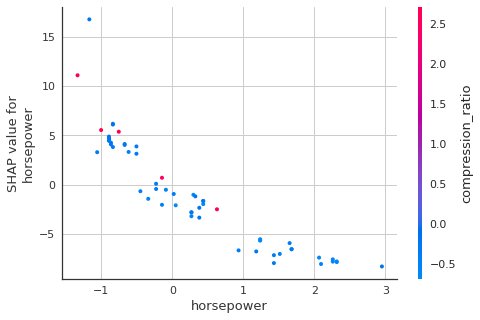

In [77]:
# Summary of HP
# As HP goes up SHAP goes down (lower mpg)
# Shap choose to show bore along with HP (more bore -> more HP)
shap.dependence_plot('horsepower', shap_values=vals, features=auto_X_test)

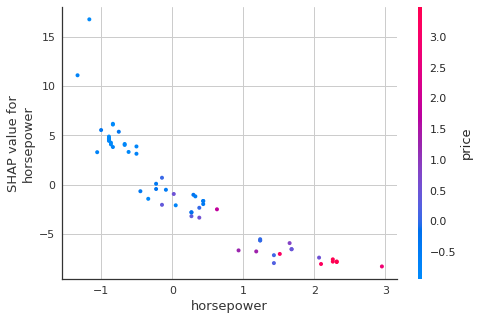

In [78]:

# Summary of HP (show w/ price)
# As HP goes up SHAP goes down (lower mpg)
# Price appears to go up as HP goes up
shap.dependence_plot('horsepower', shap_values=vals, features=auto_X_test,
                    interaction_index='price')

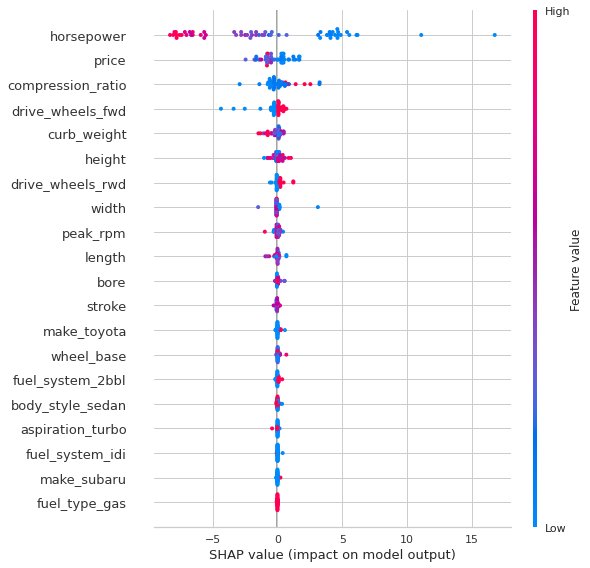

In [79]:
# Summary of features - global view
# HP is most important
#   As HP goes lower (more blue) shap goes up (as does MPG)
shap.summary_plot(vals, auto_X_test)

## Exercise - Explaining the model
Using a model for the Ames dataset:
* What are the most useful features?
* Use shap to inspect an individual result
* Use shap to inspect the summary of the features
* Use shap to inspect an individual feature

In [80]:
dt_ames = tree.DecisionTreeRegressor(max_depth=10)  # value will change w/o random state
dt_ames.fit(ames_X_train, ames_y_train)
dt_ames.score(ames_X_test, ames_y_test)

0.8156409927596903

In [81]:
dt_ames.feature_importances_

array([1.97361107e-03, 4.24529198e-03, 1.52963682e-03, 1.63971065e-03,
       1.12990563e-02, 6.16126434e-01, 5.04085245e-03, 1.00089340e-01,
       4.33541812e-03, 4.28984008e-03, 1.71884583e-02, 8.91840400e-05,
       5.93775421e-03, 1.60787552e-02, 3.58708339e-02, 2.96863192e-04,
       5.67643184e-05, 1.25372280e-01, 0.00000000e+00, 0.00000000e+00,
       1.43304626e-03, 1.49843898e-03, 3.65064160e-04, 0.00000000e+00,
       8.88372194e-04, 8.12568768e-04, 4.02316121e-03, 1.03935305e-05,
       5.52102529e-03, 4.94664709e-03, 1.98906355e-02, 5.42513692e-04,
       3.48847238e-04, 1.72375706e-03, 0.00000000e+00, 0.00000000e+00,
       5.71464937e-03, 8.20794993e-04])

In [82]:
pd.Series(dt_ames.feature_importances_, ames_X.columns)

Order              0.001974
PID                0.004245
MS SubClass        0.001530
Lot Frontage       0.001640
Lot Area           0.011299
Overall Qual       0.616126
Overall Cond       0.005041
Year Built         0.100089
Year Remod/Add     0.004335
Mas Vnr Area       0.004290
BsmtFin SF 1       0.017188
BsmtFin SF 2       0.000089
Bsmt Unf SF        0.005938
Total Bsmt SF      0.016079
1st Flr SF         0.035871
2nd Flr SF         0.000297
Low Qual Fin SF    0.000057
Gr Liv Area        0.125372
Bsmt Full Bath     0.000000
Bsmt Half Bath     0.000000
Full Bath          0.001433
Half Bath          0.001498
Bedroom AbvGr      0.000365
Kitchen AbvGr      0.000000
TotRms AbvGrd      0.000888
Fireplaces         0.000813
Garage Yr Blt      0.004023
Garage Cars        0.000010
Garage Area        0.005521
Wood Deck SF       0.004947
Open Porch SF      0.019891
Enclosed Porch     0.000543
3Ssn Porch         0.000349
Screen Porch       0.001724
Pool Area          0.000000
Misc Val           0

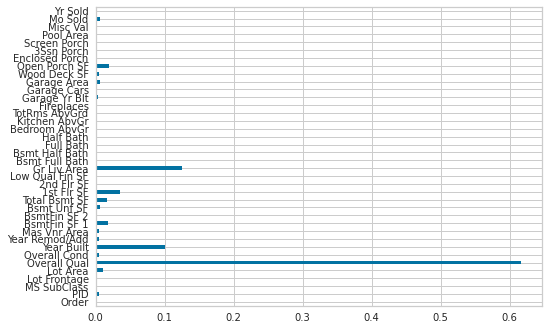

In [86]:
pd.Series(dt_ames.feature_importances_, ames_X.columns).plot.barh()

In [87]:
# Shap - Interpret black box models
shap_ex = shap.TreeExplainer(dt_ames)
vals = shap_ex.shap_values(ames_X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [88]:
# Horsepower (negative in sample)/price (also negative) increasing mpg
shap.initjs()
shap.force_plot(shap_ex.expected_value, vals[0, :], feature_names=ames_X_test.columns)

In [89]:
ames_X_test.iloc[[0]]

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold
2661,1.37575,1.008154,-0.150739,-0.286648,-0.930512,-0.84387,-1.476905,-2.278542,-1.677963,-0.59085,...,-0.760736,-0.762807,-0.726098,0.864459,-0.098452,-0.295933,-0.071084,-0.095943,-0.809715,-1.325337


In [91]:
ames_df.loc[[2661]]

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2661,2662,902325160,50,RM,63.0,5000,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,79000


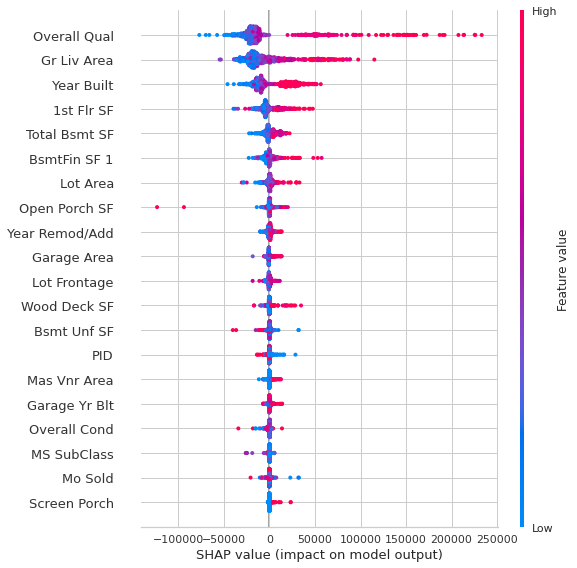

In [92]:
shap.summary_plot(vals, ames_X_test)

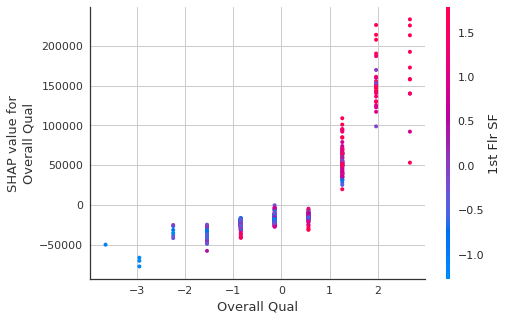

In [93]:
shap.dependence_plot('Overall Qual', shap_values=vals, features=ames_X_test)

## XGBoost
Powerful algorithm using "boosting" (like golfing) to predict target

In [94]:
dt = tree.DecisionTreeRegressor(max_depth=10)
dt.fit(auto_X_train, auto_y_train)
dt.score(auto_X_test, auto_y_test)

0.918675250691275

In [95]:
xg = xgb.XGBRFRegressor()
xg.fit(auto_X_train, auto_y_train)
xg.score(auto_X_test, auto_y_test)

0.9400387233683711

In [96]:
xg

XGBRFRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
               colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints=None,
               learning_rate=1, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=0, num_parallel_tree=100,
               objective='reg:squarederror', random_state=0, reg_alpha=0,
               reg_lambda=1e-05, scale_pos_weight=1, subsample=0.8,
               tree_method=None, validate_parameters=False, verbosity=None)

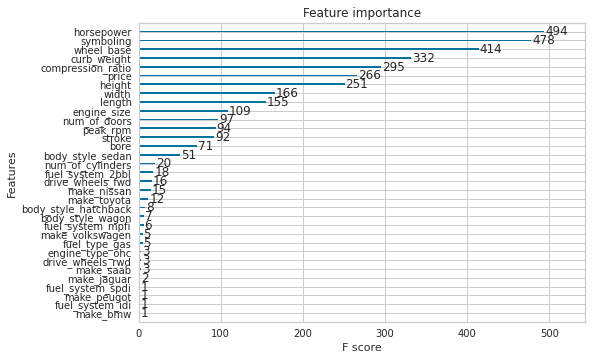

In [97]:
xgb.plot_importance(xg)

In [99]:
booster = xg.get_booster()
print(booster.get_dump()[0])

0:[horsepower<-0.477764219] yes=1,no=2,missing=1
	1:[horsepower<-1.08604956] yes=3,no=4,missing=3
		3:[width<-0.905832767] yes=7,no=8,missing=7
			7:[symboling<0.65159595] yes=15,no=16,missing=15
				15:leaf=0.444995522
				16:leaf=0.464995325
			8:[height<-0.451234579] yes=17,no=18,missing=17
				17:leaf=0.374998122
				18:[symboling<0.229609996] yes=29,no=30,missing=29
					29:leaf=0.334996641
					30:leaf=0.364996344
		4:[compression_ratio<-0.352698207] yes=9,no=10,missing=9
			9:leaf=0.254998714
			10:[curb_weight<-1.28592038] yes=19,no=20,missing=19
				19:leaf=0.364996344
				20:[height<-0.451234579] yes=31,no=32,missing=31
					31:[compression_ratio<-0.292531937] yes=43,no=44,missing=43
						43:leaf=0.282499284
						44:leaf=0.303749621
					32:[curb_weight<-0.89283812] yes=45,no=46,missing=45
						45:leaf=0.306333125
						46:leaf=0.327499181
	2:[horsepower<0.86322844] yes=5,no=6,missing=5
		5:[price<-0.161632538] yes=11,no=12,missing=11
			11:[height<-0.72222054] yes=21,no=2

In [100]:
booster = xg.get_booster()
print(booster.get_dump()[1])

0:[curb_weight<-0.420942307] yes=1,no=2,missing=1
	1:[compression_ratio<-0.0639001131] yes=3,no=4,missing=3
		3:[curb_weight<-0.839639068] yes=7,no=8,missing=7
			7:[peak_rpm<-0.511318386] yes=15,no=16,missing=15
				15:[height<-0.451234579] yes=29,no=30,missing=29
					29:leaf=0.294997036
					30:[curb_weight<-0.89283812] yes=49,no=50,missing=49
						49:leaf=0.314998955
						50:leaf=0.374996245
				16:[symboling<-0.192375958] yes=31,no=32,missing=31
					31:leaf=0.294997036
					32:leaf=0.304999769
			8:[length<-0.911293387] yes=17,no=18,missing=17
				17:[stroke<-0.735210776] yes=33,no=34,missing=33
					33:leaf=0.254998714
					34:leaf=0.234999403
				18:[peak_rpm<-0.188879579] yes=35,no=36,missing=35
					35:[price<-0.758251905] yes=51,no=52,missing=51
						51:leaf=0.309998453
						52:leaf=0.278999448
					36:[compression_ratio<-0.26846543] yes=53,no=54,missing=53
						53:leaf=0.264999568
						54:leaf=0.254998714
		4:[width<-0.905832767] yes=9,no=10,missing=9
			9:leaf=0.4449

In [101]:
booster = xg.get_booster()
print(booster.get_dump()[-1])

0:[horsepower<-0.367166877] yes=1,no=2,missing=1
	1:[horsepower<-1.08604956] yes=3,no=4,missing=3
		3:[symboling<0.65159595] yes=7,no=8,missing=7
			7:[height<-0.451234579] yes=15,no=16,missing=15
				15:leaf=0.374998122
				16:leaf=0.334996641
			8:leaf=0.464995325
		4:[engine_size<-0.585073352] yes=9,no=10,missing=9
			9:[compression_ratio<-0.219129086] yes=17,no=18,missing=17
				17:[price<-0.663225293] yes=29,no=30,missing=29
					29:[price<-0.726528943] yes=49,no=50,missing=49
						49:leaf=0.304523647
						50:leaf=0.339998275
					30:[length<-0.386106491] yes=51,no=52,missing=51
						51:leaf=0.2799986
						52:leaf=0.264997333
				18:[symboling<-0.192375958] yes=31,no=32,missing=31
					31:leaf=0.32499674
					32:leaf=0.364998162
			10:[compression_ratio<-0.256432176] yes=19,no=20,missing=19
				19:[bore<-0.0715146214] yes=33,no=34,missing=33
					33:leaf=0.264999598
					34:[compression_ratio<-0.352698207] yes=53,no=54,missing=53
						53:leaf=0.254999369
						54:leaf=0.23499

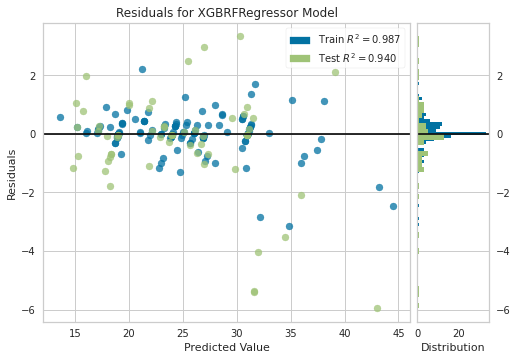

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f20bd569fd0>,
              hist=True, is_fitted='auto', line_color=None, model=None,
              test_alpha=None, test_color=None, train_alpha=None,
              train_color=None)

In [103]:
# Residuals plot 
regressor.residuals_plot(xg, auto_X_train, auto_y_train, auto_X_test, auto_y_test)

In [106]:
# viewing interactions
xgbfir.saveXgbFI(xg, feature_names=auto_X.columns, OutputXlsxFile='fir-auto.xlsx')

In [109]:
# column impmortance
# Gain - total gain of each feature
# Fscore - number of splits
# wFscore - weighted number of splits (by probability of split taking place)
pd.read_excel('fir-auto.xlsx').head(3).T

,0,1,2
Interaction,horsepower,curb_weight,compression_ratio
Gain,275212,35078.4,19410.6
FScore,494,332,295
wFScore,213.196,63.6172,59.3623
Average wFScore,0.431572,0.191618,0.201228
Average Gain,557.11,105.658,65.7985
Expected Gain,235642,26707.4,5941.31
Gain Rank,1,2,3
FScore Rank,1,4,5
wFScore Rank,1,2,3


In [110]:
# column impmortance
# Gain - total gain of each feature
# Fscore - number of splits
# wFscore - weighted number of splits (by probability of split taking place)
pd.read_excel('fir-auto.xlsx', sheet_name='Interaction Depth 1').head(3).T

,0,1,2
Interaction,horsepower|horsepower,curb_weight|horsepower,horsepower|price
Gain,365070,105404,80002.4
FScore,196,160,106
wFScore,81.655,40.9471,33.2969
Average wFScore,0.416607,0.25592,0.314121
Average Gain,1862.6,658.774,754.74
Expected Gain,179183,46648.5,40622.1
Gain Rank,1,2,3
FScore Rank,1,2,4
wFScore Rank,1,2,3


In [111]:
# column impmortance
# Gain - total gain of each feature
# Fscore - number of splits
# wFscore - weighted number of splits (by probability of split taking place)
pd.read_excel('fir-auto.xlsx', sheet_name='Interaction Depth 2').head(3).T

,0,1,2
Interaction,curb_weight|horsepower|horsepower,horsepower|horsepower|price,engine_size|horsepower|horsepower
Gain,204787,131133,93347.7
FScore,123,66,40
wFScore,26.9484,19.2601,10.141
Average wFScore,0.219093,0.29182,0.253524
Average Gain,1664.93,1986.87,2333.69
Expected Gain,56390.8,48817.4,25934.4
Gain Rank,1,2,3
FScore Rank,1,4,6
wFScore Rank,1,2,7


## XGBoost Exercise
With the Ames data
* Create an XGBoost model
* Evaluate the performance. What is the score?

In [112]:
xg_ames = xgb.XGBRFRegressor()
xg_ames.fit(ames_X_train, ames_y_train)
xg_ames.score(ames_X_test, ames_y_test)

0.8648267641339472

In [114]:
dt_ames = tree.DecisionTreeRegressor(max_depth=10)  
dt_ames.fit(ames_X_train, ames_y_train)
dt_ames.score(ames_X_test, ames_y_test)

0.8193793431302214